# Notebook to explore the universe of alternative alphabets

Goal is to write a poem that will allow complementary base pairing: i.e. the key and query of a dictionary can be flipped and still allow for a valid sentence.

https://www.pnas.org/content/114/9/2094

https://dl.acm.org/doi/10.1145/602421.602426

https://www.newscientist.com/article/mg18324595-300-do-we-have-to-spell-it-out/

https://www.cjc-online.ca/index.php/journal/article/view/2526/2291

https://en.wikipedia.org/wiki/Poem_code

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import string
import os
import shutil
import plotnine
from plotnine import *
from timeit import timeit
import string
from time import time

from math import factorial
import itertools

import importlib
import funs
importlib.reload(funs)
from funs import makeifnot
from funs import rand_mapping, alpha_trans, get_cipher, npair_max, annot_vocab_cipher
from funs import jaccard

import nltk
from nltk.tokenize import word_tokenize
import contextlib, io

import spacy

nlp_sm = spacy.load("en_core_web_sm")


def capture(fun,arg):
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        fun(arg)
    output = f.getvalue()
    return output

letters = [l for l in string.ascii_lowercase]

# There are ~ 8 billion possible alphabet encodings
print(f"There are {npair_max(letters):,} possible English alphabet encodings")

There are 7,905,853,580,625 possible English alphabet encodings


### (1) Download datasets

In [2]:
dir_code = os.getcwd()
dir_data = os.path.join(dir_code, '..', 'data')
makeifnot(dir_data)
dir_output = os.path.join(dir_code, '..', 'output')
makeifnot(dir_output)

# (1) Download the ngrams data for frequency
path_ngram = os.path.join(dir_data,'words_ngram.txt')
if not os.path.exists(path_ngram):
    !wget -q -O ../data/words_ngram.txt https://norvig.com/ngrams/count_1w.txt
else:
    print('words_ngram.txt already exists')

# (2) Download the curated dataset
path_words = os.path.join(dir_data,'words_corncob.txt')
if not os.path.exists(path_words):
    print('Downloading')
    !wget -q -O ../data/words_corncob.txt http://www.mieliestronk.com/corncob_lowercase.txt
else:
    print('corncob_lowercase.txt already exists')
#https://github.com/dwyl/english-words

words_ngram.txt already exists
corncob_lowercase.txt already exists


## (2) Load datasets

In [3]:
# (1) Load the Ngrams
df_ngram = pd.read_csv(path_ngram,sep='\t',header=None).rename(columns={0:'word',1:'n'})
df_ngram = df_ngram[~df_ngram.word.isnull()].reset_index(None, True)

# (2) Load the short word set
df_words = pd.read_csv(path_words,sep='\n',header=None).rename(columns={0:'word'})
df_words = df_words[~df_words.word.isnull()].reset_index(None, True)

# Overlap?
n_overlap = df_words.word.isin(df_ngram.word).sum()
print('A total of %i short words overlap (out of %i)' % 
     (n_overlap, df_words.shape[0]))

# Merge datasets in the intersection
df_merge = df_ngram.merge(df_words,'inner','word')
df_merge = df_merge.assign(n_sqrt=lambda x: np.sqrt(x.n), n_log=lambda x: np.log(x.n))
# Get the parts of speeach
path_spacy = os.path.join(dir_output, 'pos_spacy.csv')
if os.path.exists(path_spacy):
    pos_spacy = pd.read_csv(path_spacy)
else:
    stime, ncheck = time(), 1000
    holder = []
    for i, txt in enumerate(df_merge.word.to_list()):
        tmp = [pd.DataFrame({'word':txt,'pos':tok.pos_,'tag':tok.tag_},index=[i]) for tok in nlp_sm(txt)][0]
        holder.append(tmp)
        if (i + 1) % ncheck == 0:
            nleft, nrun, dtime = len(df_merge) - (i+1), i + 1, time() - stime
            rate = nrun / dtime
            eta = nleft / rate
            print('%0.1f calculations per second. ETA: %i seconds for %i remaining' % 
                  (rate, eta, nleft))
    pos_spacy = pd.concat(holder)
    # Get the definitions for the different tags
    dat_tag = pd.DataFrame([capture(nltk.help.upenn_tagset,p).split('\n')[0].split(': ') for p in list(pos_spacy.tag.unique())])
    dat_tag.rename(columns={0:'tag',1:'desc'}, inplace=True)
    dat_tag = dat_tag.assign(tag = lambda x: np.where(x.tag.str.len()>5,'XX',x.tag))
    pos_spacy = pos_spacy.merge(dat_tag,'left','tag')
    pos_spacy.to_csv(path_spacy,index=False)

A total of 51886 short words overlap (out of 58109)


### (3) Summary statistics on English word frequency

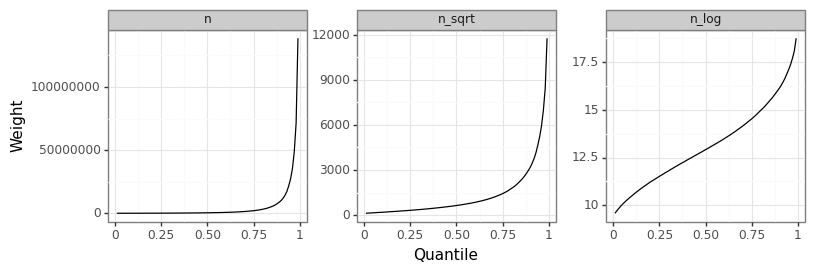

<ggplot: (8779199469877)>

In [4]:
# Examine the score frequency by percentiles
p_seq = np.arange(0.01,1,0.01)
dat_n_q = df_merge.melt('word',None,'tt').groupby('tt').value.quantile(p_seq).reset_index()
dat_n_q.rename(columns={'level_1':'qq'}, inplace=True)
dat_n_q.tt = pd.Categorical(dat_n_q.tt,['n','n_sqrt','n_log'])
di_tt = {'n':'n', 'n_sqrt':'sqrt','n_log':'log'}

# DISTIRUBTION OF WORD FREQUENCIES
plotnine.options.figure_size = (9, 2.5)
gg_q = (ggplot(dat_n_q, aes(x='qq',y='value')) + geom_path() + 
       theme_bw() + facet_wrap('~tt',scales='free_y') + 
       labs(y='Weight', x='Quantile') + 
       theme(subplots_adjust={'wspace': 0.25}))
gg_q

In [5]:
print('The ten most and least common words in the corpus')
pd.concat([df_merge.head(10)[['word','n']].reset_index(None,True),
           df_merge.tail(10)[['word','n']].reset_index(None,True)],1)

The ten most and least common words in the corpus


,word,n,word,n
0,the,23135851162,offcuts,12748
1,of,13151942776,hinderer,12737
2,and,12997637966,eminences,12734
3,to,12136980858,vaporisation,12732
4,in,8469404971,expurgated,12732
5,for,5933321709,concussed,12732
6,is,4705743816,griever,12729
7,on,3750423199,sibilance,12720
8,that,3400031103,synchronises,12719
9,by,3350048871,insatiably,12717


In [6]:
letter_freq = df_merge[['word','n']].apply(lambda x: list(x.word),1).reset_index().explode(0)
letter_freq.rename(columns={0:'letter','index':'idx'}, inplace=True)
letter_freq_n = letter_freq.merge(df_merge.rename_axis('idx').n.reset_index()).groupby('letter').n.sum().reset_index()
letter_freq_n = letter_freq_n.sort_values('n',ascending=False).reset_index(None,True)
letter_freq_n.head()

,letter,n
0,e,312191856406
1,t,225437874527
2,o,201398083835
3,a,198476530159
4,i,192368122407


### (4) 1:1 mapping system

In [7]:
# Example of random mapping
num_letters = np.arange(1,27)
di_num2let = dict(zip(num_letters, letters))
nletters = 26
Xmap = rand_mapping(1,letters, nletters)
di_map = dict(zip(Xmap[:,0], Xmap[:,1]))
rwords = df_merge.word.sample(3,random_state=1)
print(pd.DataFrame({'words':rwords, 'mapped':alpha_trans(rwords, Xmap).values}))
print('Mapping: %s' % (','.join(pd.DataFrame(Xmap).apply(lambda x: x.str.cat(sep=':'),1).to_list())))

# Show that our letter pairings are unique
for j in range(2, 13, 2):
    alphabet = letters[0:j]
    jalphabet = ''.join(alphabet)
    mx_perm = npair_max(alphabet)
    print('The first %i letters has %i mappings' % (j, mx_perm))
    malphabet = pd.Series(np.array([alpha_trans([jalphabet],get_cipher(i, alphabet)) for i in range(mx_perm)]).flat)
    assert not malphabet.duplicated().any()

         words   mapped
43284  scarcer  neqdecd
7314   adaptor  qrqzuhd
7460   distant  rmnuqsu
Mapping: s:n,r:d,w:k,t:u,e:c,v:g,o:h,x:b,q:a,p:z,y:j,i:m,l:f
The first 2 letters has 1 mappings
The first 4 letters has 3 mappings
The first 6 letters has 15 mappings
The first 8 letters has 105 mappings
The first 10 letters has 945 mappings
The first 12 letters has 10395 mappings


In [74]:
', '.join(list(np.sort(alphabet12)))

'a, c, d, e, h, i, l, n, o, r, s, t'

### (5) Exhaustive mapping for "top" 12 letters

In [23]:
alphabet12 = letter_freq_n.letter[0:12].to_list()
jalphabet12 = ''.join(alphabet12)
df_merge12 = df_merge[~df_merge.word.str.contains('[^'+jalphabet12+']')]
words12 = df_merge12.word
print('There are %i unique words using the top 12 letters' % (len(words12)))

mx_perm12 = npair_max(alphabet12)
di_eval = {0:'idx', 1:'n', 2:'w', 3:'sw', 4:'ln'}

path12 = os.path.join(dir_output,'dat_12.csv')
if os.path.exists(path12):
    dat_12 = pd.read_csv(path12)
else:
    holder = [] # np.zeros(mx_perm12,dtype=int)
    stime, ncheck = time(), 1000
    for i in range(mx_perm12):
        xmap_i = get_cipher(i, alphabet12)
        words_i = words12[alpha_trans(pd.Series(words12), xmap_i).isin(words12)]
        df_i = df_merge12.query('word.isin(@words_i)')
        df_i = pd.DataFrame(np.append([i, len(df_i)],df_i.mean().values)).T.rename(columns=di_eval)
        holder.append(df_i)
        if (i + 1) % ncheck == 0:
            nleft, nrun, dtime = mx_perm12 - (i+1), i + 1, time() - stime
            rate = nrun / dtime
            eta = nleft / rate
            print('%0.1f calculations per second. ETA: %i seconds for %i remaining' % 
                  (rate, eta, nleft))
    dat_12 = pd.concat(holder)
    dat_12[['idx','n']] = dat_12[['idx','n']].astype(int)
    dat_12 = dat_12.sort_values('n',ascending=False).reset_index(None,True)
    dat_12.to_csv(path12,index=False)

There are 6532 unique words using the top 12 letters


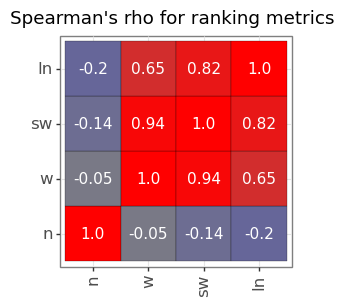

<ggplot: (8779056812065)>

In [24]:
# How rank-correlated are the different measures?
cn_msr = dat_12.columns.drop('idx')
holder = []
for cn1 in cn_msr:
    for cn2 in cn_msr:
        holder.append(pd.DataFrame({'cn1':cn1, 'cn2':cn2, 'rho':stats.spearmanr(dat_12[cn1], dat_12[cn2])[0]},index=[0]))
dat_rho = pd.concat(holder).assign(cn1=lambda x: pd.Categorical(x.cn1, cn_msr),
                                   cn2=lambda x: pd.Categorical(x.cn2, cn_msr))
plotnine.options.figure_size = (3, 3)
gg_rho = (ggplot(dat_rho, aes(x='cn1',y='cn2',fill='rho')) + 
        theme_bw() + geom_tile(color='black') + 
        theme(axis_title=element_blank(),axis_text=element_text(size=12),
              axis_text_x=element_text(angle=90)) + 
         scale_fill_gradient2(low='blue',high='red',mid='grey',midpoint=0) + 
          guides(fill=False) + 
         geom_text(aes(label='rho.round(2)'),color='white') + 
         ggtitle("Spearman's rho for ranking metrics"))
gg_rho

In [25]:
# "best" word list from each
metric_idx = dat_12.melt('idx',None,'metric').sort_values(['metric','value'],ascending=False).groupby('metric').head(1)
metric_idx.reset_index(None,True,inplace=True)

for i, r in metric_idx.iterrows():
    idx, metric = r['idx'], r['metric']
    vocab_i = annot_vocab_cipher(corpus=words12, cipher=get_cipher(idx, alphabet12), PoS=pos_spacy)
    print('Metric: %s has %i words' % (metric, len(vocab_i)))

Metric: w has 6 words
Metric: sw has 6 words
Metric: n has 132 words
Metric: ln has 8 words


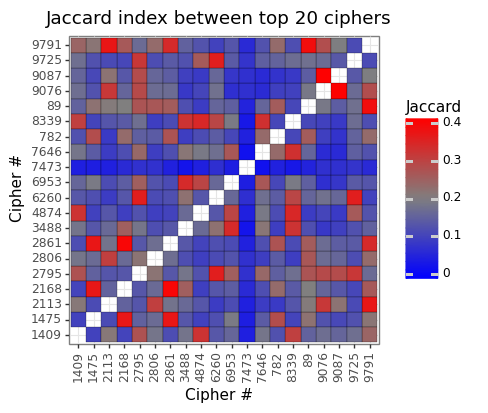

<ggplot: (8779057298013)>

In [68]:
# What is the jaccard index for the top 20 ciphers?
k = 20
top_idx = dat_12.head(k).idx.values
holder = []
for i in range(0, k):
    idx_i = top_idx[i]
    xmap_i = get_cipher(idx_i, alphabet12)
    words_i = words12[alpha_trans(pd.Series(words12), xmap_i).isin(words12)]
    for j in range(k):
        idx_j = top_idx[j]
        xmap_j = get_cipher(idx_j, alphabet12)
        words_j = words12[alpha_trans(pd.Series(words12), xmap_j).isin(words12)]
        jac_ij = jaccard(words_i, words_j)
        holder.append(pd.DataFrame({'idx1':idx_i, 'idx2':idx_j, 'jac':jac_ij},index=[0]))
res_jac = pd.concat(holder).reset_index(None,True)
res_jac = res_jac.assign(idx1=lambda x: x.idx1.astype(str),
                         idx2=lambda x: x.idx2.astype(str)).query('idx1 != idx2')
plotnine.options.figure_size = (4, 4)
gg_jac = (ggplot(res_jac, aes(x='idx1', y='idx2', fill='jac')) + theme_bw() + 
          geom_tile(color='black') + 
          labs(y='Cipher #',x='Cipher #') + 
          scale_fill_gradient2(name='Jaccard',low='blue',mid='grey',high='red',
                               midpoint=0.2,breaks=np.arange(0,0.51,0.1),limits=(0,0.4)) + 
          theme(axis_text_x=element_text(angle=90)) + 
          ggtitle('Jaccard index between top 20 ciphers'))
gg_jac

In [ ]:
# # Get the different Parts-of-Speech values: USE DF_MERGE


## Thinking about the Shiny App

1. Let users pick a number from 1 to 56 billion, or a "top" number
2. Let users pick which letters they want in the alphabet (a,b,c,d,e,f for example)
3. Users type in the left box, translation happens in the right
4. Enable auto-complete with GPT-2 or some such thing
5. Show word list: organized by nouns, verbs, adjectives, etc

In [ ]:
# def forwardPerm(idx, lst):
#     alst = lst.copy()  # Active copy
#     holder = []  # Store the list combination and index
#     for j in range(len(lst)):
#         if len(alst) == 1:  # Terminate when there is one element less
#             q = 0
#             v = alst[q]
#             holder.append([v, q])
#             break
#         else:
#             nperm = factorial(len(alst)-1)
#             q, r = divmod(idx, nperm)
#             v = alst[q]
#             alst.remove(v)  # Remove v from the list
#             idx = r
#             holder.append([v, q])
#     return holder


# dat = pd.concat([pd.DataFrame(forwardPerm(i,letters[0:4])).assign(idx=i) for i in range(24)])
# dat.rename(columns={0:'letter', 1:'q'},inplace=True)
# dat.groupby(['letter','q']).size().reset_index().rename(columns={0:'n'})

In [ ]:
# txt = words.sample(13,random_state=1).copy()
# trans = alpha_trans(txt, Xmap)
# df_example = pd.concat([pd.DataFrame(Xmap,columns=['from','to']),
#                         pd.DataFrame({'original':txt, 'mapped':trans}).reset_index(None,True)],1)
# print(df_example)  #[['from','to']]

In [ ]:
# from time import time

# nsim = 80000
# tnow = time()

# holder = []
# for ii in range(nsim):
#     if (ii+1) % 10000 == 0:
#         tdiff = time() - tnow
#         print('Simulation %i of %i (took %i seconds)' % (ii+1, nsim, tdiff))
#         tnow = time()
#     # Generate a random mapping
#     Xmap = gen_mapping(ii, letters, nletters)
#     words = words[words.notnull()].reset_index(None,True)
#     trans = alpha_trans(words.copy(), Xmap)
#     idx = trans.isin(words)
#     df = pd.DataFrame({'original':words[idx],'mapped':trans[idx],'seed':ii})
#     holder.append(df)
# dat_sim = pd.concat(holder).reset_index(None,True)